## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import utils as u
from time import time

from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

# sklearn
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve

from sklearn.metrics import classification_report, roc_auc_score

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
import importlib

In [23]:
importlib.reload(u)

<module 'utils' from '/Volumes/Mac HD 1TB/Identify_CustomerSegments/Arvato Project/utils.py'>

## Preprocessing train data

In [2]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.drop(columns='Unnamed: 0', inplace=True)


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Also the attribute file will come in handy for handling missing or unknown values
dictionary = pd.read_excel('DIAS Attributes - Values 2017_revised.xlsx', sheet_name='Tabelle1')
dictionary.drop(columns='Unnamed: 0', inplace=True)

In [4]:
column_dist = mailout_train.isnull().sum()
column_dist.sort_values(ascending=False, inplace=True)
outlier_columns = column_dist.index[:8]
print(column_dist[:30]/mailout_train.shape[0])

ALTER_KIND4       0.999046
ALTER_KIND3       0.995950
ALTER_KIND2       0.982403
ALTER_KIND1       0.953727
KK_KUNDENTYP      0.589265
EXTSEL992         0.371212
HH_DELTA_FLAG     0.225269
W_KEIT_KIND_HH    0.225269
KBA05_KW2         0.201294
MOBI_REGIO        0.201294
KBA05_KW3         0.201294
KBA05_MAXAH       0.201294
KBA05_MAXBJ       0.201294
KBA05_MAXHERST    0.201294
KBA05_MOTRAD      0.201294
KBA05_MAXVORB     0.201294
KBA05_MOD1        0.201294
KBA05_MOD2        0.201294
KBA05_MOD3        0.201294
KBA05_MOD4        0.201294
KBA05_MOD8        0.201294
KBA05_MOTOR       0.201294
KBA05_KW1         0.201294
KBA05_MAXSEG      0.201294
KBA05_ZUL2        0.201294
KBA05_SEG1        0.201294
KBA05_SEG7        0.201294
KBA05_ZUL1        0.201294
KBA05_VORB2       0.201294
KBA05_VORB1       0.201294
dtype: float64


In [5]:
cat_col = u.obtain_categorical_columns(mailout_train)
cat_col

{'multi': ['LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'TITEL_KZ',
  'VERS_TYP',
  'CJT_GESAMTTYP',
  'CAMEO_DEUG_2015',
  'FINANZTYP',
  'GEBAEUDETYP',
  'GFK_URLAUBERTYP',
  'ZABEOTYP'],
 'binary': ['OST_WEST_KZ', 'ANREDE_KZ', 'GREEN_AVANTGARDE']}

In [6]:
unknown_dict = u.create_unknown_dictionary(dictionary)

Shape of the attribute file: (2258, 4)
Missing values in the array: 11
After filling NaNs with False: 
False    2025
True      233
Name: Meaning, dtype: int64


In [7]:
#Cleaning 
mailout_train, mailout_high_nas = u.clean_mailout(mailout_train.copy(), unknown_dict, outlier_columns, cat_col)

Splitting records with NAs..
 Total records: 42962
Records split by 89 missing values.
 Shape of resulting dataset: (34991,)
 Shape of high NAs dataset: (7971,)



/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
# Creating X_train and Y_train
X = mailout_train.drop(columns=['RESPONSE'])
y = mailout_train.RESPONSE

X.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE,EINGEFUEGT_AM_YEAR
0,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,0,1,0,0,0,0.0,40.0,3.0,4.0,1992.0
1,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0,0,0,0,0,0.0,70.0,3.0,2.0,1997.0
2,1.0,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,...,0,1,0,0,0,1.0,40.0,1.0,4.0,1995.0
3,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,0,1,0,0,0,1.0,40.0,1.0,4.0,1992.0
4,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,0,1,0,0,0,0.0,50.0,4.0,1.0,1992.0


In [9]:
X.describe(include=['object'])

,D19_LETZTER_KAUF_BRANCHE
count,34412
unique,35
top,D19_UNBEKANNT
freq,9986


In [10]:
# There is nothing related to the 'D19_LETZTER_KAUF_BRANCHE' column in the dictionary file, so we drop it (Also some of 
# its values arleady exist as columns in the dataset)
X.drop(columns=['D19_LETZTER_KAUF_BRANCHE'], inplace=True)

### Training and Evaluation

It's good practice to split the data into training and testing sets. However, there are also other approaches such as cross validation. I will use this one (5 folds) along with GridSearchCV due to the imbalance of the data. The supervised methods used will be Random Forest Classifier, AdaBoost, SGD and Gradient Boosting Classifier.

### Random Forest Classifier

In [11]:
transformer = Pipeline([
    ('imp', Imputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())
])

In [12]:
# Let's create a RF Pipeline first
pipeline_rf = Pipeline([
        ('transf', transformer),
        ('clf', RandomForestClassifier())
    ])

In [13]:
# Parameters to consider
pipeline_rf.get_params()

{'memory': None, 'steps': [('transf', Pipeline(memory=None,
        steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])),
  ('clf',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False))], 'transf': Pipeline(memory=None,
      steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), 'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=

In [14]:
parameters_rf = {
    'clf__n_estimators': [10,30,50,100],
    'clf__min_samples_split': [3,4,7,10],
}

# Using GridSearch to find the best set of parameters, also considering ROC to evaluate
# due to the imbalanced data
cv_rf = GridSearchCV(estimator=pipeline_rf,param_grid=parameters_rf, scoring='roc_auc',
                     n_jobs=-1, verbose=1, cv=5, return_train_score = True)

In [15]:
# Training Random Forest algorithm
t0 = time()
cv_rf.fit(X,y)
print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.7min finished


done in 174.980s


In [16]:
print("\nBest Score: ", cv_rf.best_score_)
print("\nBest Parameters: ", cv_rf.best_params_)
print("\nBest Estimator: ", cv_rf.best_estimator_)


Best Score:  0.6474752742693168

Best Parameters:  {'clf__min_samples_split': 7, 'clf__n_estimators': 100}

Best Estimator:  Pipeline(memory=None,
     steps=[('transf', Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
    ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])


In [17]:
df_cv_results = pd.DataFrame(cv_rf.cv_results_)
df_cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 22 columns):
mean_fit_time                   16 non-null float64
std_fit_time                    16 non-null float64
mean_score_time                 16 non-null float64
std_score_time                  16 non-null float64
param_clf__min_samples_split    16 non-null object
param_clf__n_estimators         16 non-null object
params                          16 non-null object
split0_test_score               16 non-null float64
split1_test_score               16 non-null float64
split2_test_score               16 non-null float64
split3_test_score               16 non-null float64
split4_test_score               16 non-null float64
mean_test_score                 16 non-null float64
std_test_score                  16 non-null float64
rank_test_score                 16 non-null int32
split0_train_score              16 non-null float64
split1_train_score              16 non-null float64
split2_train_score

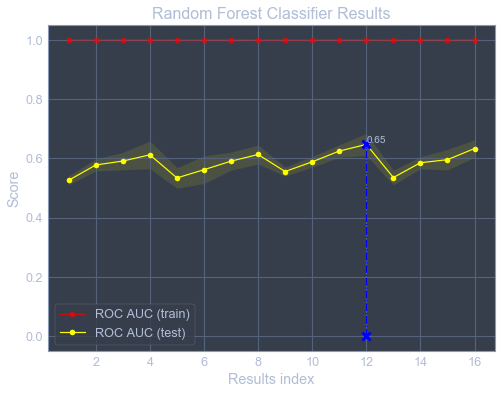

In [18]:
u.plot_cv_results(df_cv_results, "Random Forest Classifier Results")

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

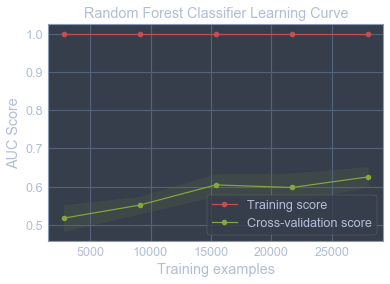

In [24]:
u.plot_learning_curve(cv_rf.best_estimator_, 'Random Forest Classifier Learning Curve',X, y)

### AdaBoost Classifier

In [25]:
# Building pipeline for AdaBoost
pipeline_ada= Pipeline([
        ('transf', transformer),
        ('clf', AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))
    ])


In [26]:
pipeline_ada.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('transf', Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeCla...ne,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None))])>

In [27]:
parameters_ada = {
    'clf__base_estimator__max_depth': [3,5,7],
    'clf__n_estimators': [70,100],
    'clf__random_state': [42],
    'clf__learning_rate': [0.01, 0.001]
}
cv_ada = GridSearchCV(estimator=pipeline_ada,param_grid=parameters_ada, scoring='roc_auc', 
                      n_jobs=-1, verbose=1, cv=5, return_train_score=True)

In [28]:
# Training AdaBoost
t0 = time()
cv_ada.fit(X, y)
print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.2min finished


done in 1308.037s


In [29]:
print("\nBest Score: ", cv_ada.best_score_)
print("\nBest Parameters: ", cv_ada.best_params_)
print("\nBest Estimator: ", cv_ada.best_estimator_)


Best Score:  0.7805694224953068

Best Parameters:  {'clf__base_estimator__max_depth': 7, 'clf__learning_rate': 0.001, 'clf__n_estimators': 70, 'clf__random_state': 42}

Best Estimator:  Pipeline(memory=None,
     steps=[('transf', Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeCla...ne,
            splitter='best'),
          learning_rate=0.001, n_estimators=70, random_state=42))])


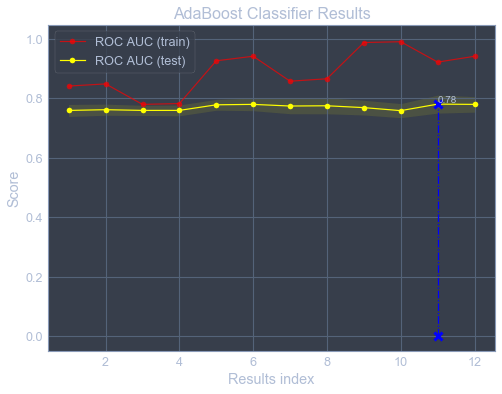

In [30]:
u.plot_cv_results(pd.DataFrame(cv_ada.cv_results_), 'AdaBoost Classifier Results')

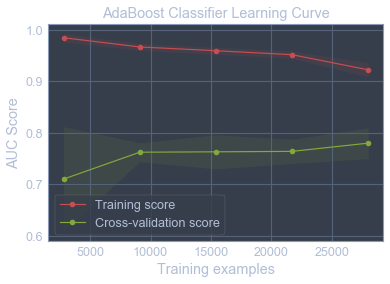

In [31]:
u.plot_learning_curve(cv_ada.best_estimator_, 'AdaBoost Classifier Learning Curve',X, y);

### SGM Classifier

In [32]:
# Building pipeline for SGD
pipeline_sgd= Pipeline([
    ('transf', transformer),
    ('clf', SGDClassifier())
    ])

In [33]:
pipeline_sgd.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('transf', Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
     ...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])>

In [34]:
parameters_sgd = {
    'clf__loss': ['perceptron','modified_huber'],
    'clf__penalty': ['l1'],
    'clf__max_iter': [1500],
    'clf__tol': [None],
    'clf__class_weight': ['balanced', None]
}
cv_sgd = GridSearchCV(estimator=pipeline_sgd,param_grid=parameters_sgd, scoring='roc_auc', 
                      n_jobs=-1, verbose=1, cv=5, return_train_score=True)

In [35]:
# Training SGD
t0 = time()
cv_sgd.fit(X,y)
print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.9min finished


done in 562.255s


In [36]:
print("\nBest Score: ", cv_sgd.best_score_)
print("\nBest Parameters: ", cv_sgd.best_params_)
print("\nBest Estimator: ", cv_sgd.best_estimator_)


Best Score:  0.6928237755479874

Best Parameters:  {'clf__class_weight': None, 'clf__loss': 'perceptron', 'clf__max_iter': 1500, 'clf__penalty': 'l1', 'clf__tol': None}

Best Estimator:  Pipeline(memory=None,
     steps=[('transf', Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
     ...='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])


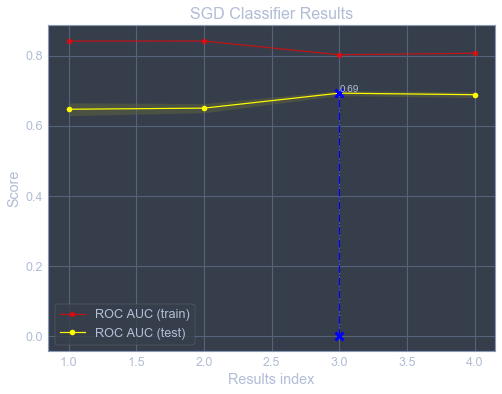

In [37]:
u.plot_cv_results(pd.DataFrame(cv_sgd.cv_results_), 'SGD Classifier Results')

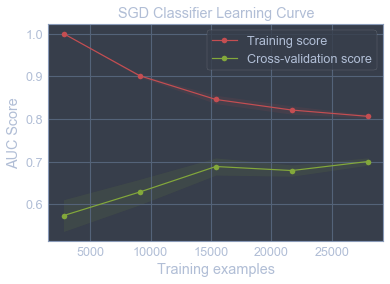

In [38]:
u.plot_learning_curve(cv_sgd.best_estimator_, 'SGD Classifier Learning Curve',X, y);

### Gradient Boosting Classifier

In [39]:
# Building pipeline for GradientBoosting Classifier
pipeline_gbc= Pipeline([
    ('transf', transformer),
    ('clf', GradientBoostingClassifier())
    ])

In [40]:
pipeline_gbc.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('transf', Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              le...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])>

In [41]:
parameters_gbc = {
    'clf__n_estimators': [100,300],
    'clf__learning_rate': [0.1,0.001],
    'clf__max_depth':[3,5]
}
cv_gbc = GridSearchCV(estimator=pipeline_gbc,param_grid=parameters_gbc, scoring='roc_auc', 
                      n_jobs=-1, verbose=1, cv=5, return_train_score=True)

In [42]:
# Training GBC
t0 = time()
cv_gbc.fit(X,y)
print("done in %0.3fs" % (time() - t0))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 32.9min finished


done in 2094.141s


In [43]:
print("\nBest Score: ", cv_gbc.best_score_)
print("\nBest Parameters: ", cv_gbc.best_params_)
print("\nBest Estimator: ", cv_gbc.best_estimator_)


Best Score:  0.775233417541766

Best Parameters:  {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}

Best Estimator:  Pipeline(memory=None,
     steps=[('transf', Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              le...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])


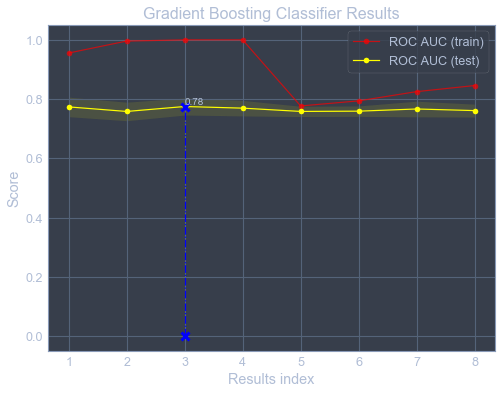

In [44]:
u.plot_cv_results(pd.DataFrame(cv_gbc.cv_results_), 'Gradient Boosting Classifier Results')

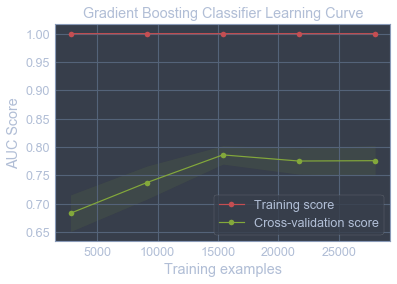

In [45]:
u.plot_learning_curve(cv_gbc.best_estimator_,'Gradient Boosting Classifier Learning Curve', X,y);

In [46]:
# Saving all the three models
u.save_model(cv_rf.best_estimator_, 'rf')
u.save_model(cv_ada.best_estimator_, 'ada')
u.save_model(cv_sgd.best_estimator_, 'sgd')
u.save_model(cv_gbc.best_estimator_, 'gbc')

rf_model.pkl saved
ada_model.pkl saved
sgd_model.pkl saved
gbc_model.pkl saved
